##### Library Installation

In [111]:
# uncomment this cell to install the following libraries.
# follow the below link to use gpu. prefer to use windows native (with tensorflow 2.10) because it is easier to install.
# https://www.tensorflow.org/install/pip
#%pip install numpy
#%pip install pandas
#%pip install ta
#%pip install matplotlib
#%pip install scikit-learn
#%pip install tensorflow
#%pip install ipympl

##### Imports

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers
from keras import Input
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from ta import momentum
from ta import volume
from ta import volatility
from ta import trend


##### Miscellaneous

In [113]:
# Used for interactive plots (zooming in)
%matplotlib widget

np.set_printoptions(threshold=np.inf, linewidth=300)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data acquisition method

##### Load from file (obtained through data extraction tool)

In [114]:
stock_ticker = 'AMZN'
df = pd.read_csv('ta_stock_data_' + stock_ticker + '.csv')

start_date = df['Date'].iloc[0]
end_date = df['Date'].iloc[-1]
print('Time Period: ' + str(start_date) + ' to ' + str(end_date))

df

Time Period: 2013-09-25 to 2023-09-22


,Date,Open,High,Low,Close,Volume
0,2013-09-25,15.7265,15.8355,15.5375,15.6325,40172000
1,2013-09-26,15.6950,15.9685,15.6630,15.9060,39798000
2,2013-09-27,15.8460,15.8605,15.6675,15.8005,33150000
3,2013-09-30,15.6705,15.7655,15.5530,15.6320,32472000
4,2013-10-01,15.7110,16.0500,15.6825,16.0475,47928000
...,...,...,...,...,...,...
2511,2023-09-18,140.4800,141.7500,139.2200,139.9800,42823500
2512,2023-09-19,138.7000,138.8400,135.5600,137.6300,61482500
2513,2023-09-20,138.5500,139.3700,135.2000,135.2900,46263700
2514,2023-09-21,131.9400,132.2400,129.3100,129.3300,70234800


# Data Transform

In [115]:
# To add a new TA column, simply follow the examples shown. Some TA might have more than one function, such as MACD - it is not necessary to use them, but might as well have them!
# Use the ta library documentation to find more indicators for each of the below categories.
# Hover over the TA class to see what data is needed, for example: open, high, low, close, volume
# Some TA classes needs a window, which you can optionally add as an argument.

# Momentum
df['rsi'] = momentum.RSIIndicator(df['Close'], window=10).rsi()
df['awesome_oscillator'] = momentum.AwesomeOscillatorIndicator(df['High'], df['Low'], window1=5, window2=30).awesome_oscillator()

# Volume
df['force_index'] = volume.ForceIndexIndicator(df['Close'], df['Volume'], window=10).force_index()
df['ease_of_movement'] = volume.EaseOfMovementIndicator(df['High'], df['Low'], df['Volume'], window=10).ease_of_movement()
df['ease_of_movement_signal'] = volume.EaseOfMovementIndicator(df['High'], df['Low'], df['Volume'], window=10).sma_ease_of_movement()

# Volatility
df['bbands_upper'] = volatility.BollingerBands(df['Close'], window=10).bollinger_hband()
df['bbands_middle'] = volatility.BollingerBands(df['Close'], window=10).bollinger_mavg()
df['bbands_lower'] = volatility.BollingerBands(df['Close'], window=10).bollinger_lband()
df['atr'] = volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=10).average_true_range()

# Trend
df['macd'] = trend.MACD(df['Close'], window_slow=20, window_fast=10, window_sign=9).macd()
df['macd_signal'] = trend.MACD(df['Close'], window_slow=20, window_fast=10, window_sign=9).macd_signal()
df['aroon'] = trend.AroonIndicator(df['Close'], window=20).aroon_indicator()
df['aroon_up'] = trend.AroonIndicator(df['Close'], window=20).aroon_up()
df['aroon_down'] = trend.AroonIndicator(df['Close'], window=20).aroon_down()



In [116]:
# Drop NaN values, which typically includes the first few rows where TA values are NaN
df.dropna(inplace=True)

In [117]:
print(df.shape)
print(df.columns)
print(df.isnull().sum())

(2487, 20)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'rsi',
       'awesome_oscillator', 'force_index', 'ease_of_movement',
       'ease_of_movement_signal', 'bbands_upper', 'bbands_middle',
       'bbands_lower', 'atr', 'macd', 'macd_signal', 'aroon', 'aroon_up',
       'aroon_down'],
      dtype='object')
Date                       0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
rsi                        0
awesome_oscillator         0
force_index                0
ease_of_movement           0
ease_of_movement_signal    0
bbands_upper               0
bbands_middle              0
bbands_lower               0
atr                        0
macd                       0
macd_signal                0
aroon                      0
aroon_up                   0
aroon_down                 0
dtype: int64


##### Preparing data for loading into model

In [118]:
df_copy = df.copy() # used for plotting values
df.drop(['Date'], axis=1, inplace=True)

In [119]:
# Swap close price with open price, since predicting the price the stock closes at is more helpful.
col_loc = df.columns.get_loc('Close')
if col_loc != 0:
    cols = list(df.columns)
    a, b = cols.index('Close'), cols.index(df.columns[0])
    cols[b], cols[a] = cols[a], cols[b]
    df = df[cols]

In [120]:
# Scale the data
df_columns = df.columns

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)    # fit and transform to all data
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_columns

scaler_price = MinMaxScaler(feature_range=(0, 1))   # fit to data, used by graphs to plot prices instead of values in the (0, 1) range
scaler_price.fit(df[['Close']])

df_scaled

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.020886,0.020028,0.020757,0.020921,0.049002,0.688932,0.645302,0.685427,0.484850,0.577921,0.022010,0.018012,0.017919,0.019088,0.639886,0.650436,0.921053,0.842105,0.000000
1,0.020099,0.020803,0.020658,0.021982,0.060980,0.637029,0.643210,0.682521,0.485361,0.578402,0.020600,0.018884,0.021241,0.018843,0.637737,0.650819,0.894737,0.789474,0.000000
2,0.016435,0.019376,0.016960,0.020656,0.146465,0.442045,0.639627,0.674301,0.481407,0.577189,0.019120,0.019221,0.023538,0.023669,0.632528,0.649883,0.815789,0.736842,0.105263
3,0.018395,0.017409,0.017593,0.017791,0.077285,0.521188,0.635934,0.676390,0.484253,0.575575,0.018891,0.018833,0.022988,0.022385,0.629913,0.648510,0.815789,0.684211,0.052632
4,0.019576,0.018650,0.018771,0.019132,0.060083,0.564370,0.633493,0.677024,0.486326,0.576070,0.018814,0.018721,0.022841,0.021112,0.628602,0.647099,0.815789,0.631579,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.729476,0.730643,0.732656,0.729911,0.054837,0.488190,0.707812,0.653309,0.417884,0.647193,0.739401,0.745073,0.736429,0.398248,0.704818,0.716669,0.842105,0.842105,0.157895
2483,0.715831,0.713931,0.711207,0.719621,0.095445,0.403809,0.692015,0.639199,0.337094,0.620361,0.739221,0.745287,0.737064,0.412872,0.682016,0.714367,0.842105,0.789474,0.105263
2484,0.702244,0.716975,0.709097,0.718754,0.062324,0.331356,0.671358,0.632119,0.491367,0.637179,0.739312,0.745245,0.736880,0.422735,0.652339,0.705447,0.842105,0.736842,0.052632
2485,0.667637,0.676029,0.674580,0.680541,0.114492,0.195611,0.622923,0.588081,0.255847,0.574008,0.750688,0.740191,0.714154,0.455489,0.600268,0.685890,0.342105,0.684211,1.000000


In [121]:
features = df_scaled
features = features.drop(['Close'], axis=1) # drop the 'close' column from features
target = df_scaled[['Close']]    # Prediction target. 

In [122]:
features

,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.020028,0.020757,0.020921,0.049002,0.688932,0.645302,0.685427,0.484850,0.577921,0.022010,0.018012,0.017919,0.019088,0.639886,0.650436,0.921053,0.842105,0.000000
1,0.020803,0.020658,0.021982,0.060980,0.637029,0.643210,0.682521,0.485361,0.578402,0.020600,0.018884,0.021241,0.018843,0.637737,0.650819,0.894737,0.789474,0.000000
2,0.019376,0.016960,0.020656,0.146465,0.442045,0.639627,0.674301,0.481407,0.577189,0.019120,0.019221,0.023538,0.023669,0.632528,0.649883,0.815789,0.736842,0.105263
3,0.017409,0.017593,0.017791,0.077285,0.521188,0.635934,0.676390,0.484253,0.575575,0.018891,0.018833,0.022988,0.022385,0.629913,0.648510,0.815789,0.684211,0.052632
4,0.018650,0.018771,0.019132,0.060083,0.564370,0.633493,0.677024,0.486326,0.576070,0.018814,0.018721,0.022841,0.021112,0.628602,0.647099,0.815789,0.631579,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.730643,0.732656,0.729911,0.054837,0.488190,0.707812,0.653309,0.417884,0.647193,0.739401,0.745073,0.736429,0.398248,0.704818,0.716669,0.842105,0.842105,0.157895
2483,0.713931,0.711207,0.719621,0.095445,0.403809,0.692015,0.639199,0.337094,0.620361,0.739221,0.745287,0.737064,0.412872,0.682016,0.714367,0.842105,0.789474,0.105263
2484,0.716975,0.709097,0.718754,0.062324,0.331356,0.671358,0.632119,0.491367,0.637179,0.739312,0.745245,0.736880,0.422735,0.652339,0.705447,0.842105,0.736842,0.052632
2485,0.676029,0.674580,0.680541,0.114492,0.195611,0.622923,0.588081,0.255847,0.574008,0.750688,0.740191,0.714154,0.455489,0.600268,0.685890,0.342105,0.684211,1.000000


In [123]:
target

,Close
0,0.020886
1,0.020099
2,0.016435
3,0.018395
4,0.019576
...,...
2482,0.729476
2483,0.715831
2484,0.702244
2485,0.667637


##### Train Data Setup

In [124]:
dataset = df_scaled.to_numpy()
train_data_percent = 0.9   # percentage of data used for training
train_data_len = math.ceil(len(dataset) * train_data_percent)

In [125]:
print(len(df_scaled[0:train_data_len]))
print(len(dataset[0:train_data_len]))

2239
2239


In [126]:
train_x = features[0:train_data_len].to_numpy()
train_y = target[0:train_data_len].to_numpy()

In [127]:
print(train_x.shape)
print(train_y.shape)

(2239, 18)
(2239, 1)


In [128]:
# preparing the train data as a sliding window
x_train_sw = []
y_train_sw = []

# The sliding window size (in days) we use as input. There are 5 trading days in a week
sliding_window_size = 5
for i in range(sliding_window_size, len(train_x)):
    x_train_sw.append(train_x[i-sliding_window_size:i,:])
    y_train_sw.append(train_y[i:i+1, 0])

x_train_sw, y_train_sw = np.array(x_train_sw), np.array(y_train_sw)   # convert to numpy array

# Transformer Model

In [129]:
def transformer_encoder(
    inputs, 
    head_size, 
    num_heads, 
    ff_dim, 
    dropout=0.0
):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [130]:
# This function builds the model.
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.0,
    mlp_dropout=0.0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)    # this tells us that the output is one prediction step.
    return Model(inputs, outputs)

In [131]:
input_shape = x_train_sw.shape[1:]
print(x_train_sw.shape)     # (data points, sliding window, features)
print(input_shape)          # (sliding window, features)
print(y_train_sw.shape)     # (data points, target)

(2234, 5, 18)
(5, 18)
(2234, 1)


##### Model Callbacks

In [132]:
# Adding EarlyStopping callback (for lots of epochs)
early_stopping = [EarlyStopping(patience=5, restore_best_weights=True)]

# Adding ModelCheckpoint callback
# Define the path to save the best weights. The best weights will be used for stock prediction.
checkpoint_path = 'best_weights.h5'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)


model_callbacks = [early_stopping, checkpoint]

##### Model Creation and Training

In [133]:
# The model is ready to be built and trained!
# You can tune the model here.
input_shape = (sliding_window_size, input_shape[1])
model = build_model(
    input_shape,
    head_size=512,
    num_heads=16,
    ff_dim=16,
    num_transformer_blocks=16,
    mlp_units=[512],
    mlp_dropout=0.05,
    dropout=0.05,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['mse', 'mae', 'mape']
)

model.summary()

# General guidelines for hyperparameters
# - head_size and mlp_units should be large values (i.e. 256 for head_size and mlp_units, 8 num_heads, ff_dim, num_transformer_blocks)
# - you can't just keep increasing the hyperparameter values, memory is your constraint.
# - dropout at 0.05 seems to give better results than higher values, but needs more testing.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 18)]      0           []                               
                                                                                                  
 layer_normalization_64 (LayerN  (None, 5, 18)       36          ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_32 (Multi  (None, 5, 18)       614418      ['layer_normalization_64[0][0]', 
 HeadAttention)                                                   'layer_normalization_64[0][0]'] 
                                                                                            

##### Model Fitting

In [134]:
# Train the model with the callback
train_validation_split = 0.2  # 0.2 means 80% train and 20% validation. Higher = less train, more validation.
history = model.fit(
            x_train_sw,
            y_train_sw,
            validation_split=train_validation_split,
            epochs=20,
            batch_size=128,
            callbacks=model_callbacks
          )

# Load the best weights into the model
model.load_weights('best_weights.h5')

Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 0.0636 - mse: 0.0636 - mae: 0.1840 - mape: 8656.1992
Epoch 1: val_loss improved from inf to 0.01233, saving model to best_weights.h5
14/14 [==============================] - 21s 504ms/step - loss: 0.0636 - mse: 0.0636 - mae: 0.1840 - mape: 8656.1992 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0847 - val_mape: 11.9013
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.0149 - mse: 0.0149 - mae: 0.0912 - mape: 30578.9824
Epoch 2: val_loss improved from 0.01233 to 0.01006, saving model to best_weights.h5
14/14 [==============================] - 5s 359ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0912 - mape: 30578.9824 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0755 - val_mape: 10.4702
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0082 - mae: 0.0660 - mape: 6756.4819
Epoch 3: val_loss did not improve from 0.01006
14/14 [==============================] - 

# Validation and Testing

##### Test Data Setup

In [135]:
test_x = features[train_data_len:].to_numpy()
test_y = target[train_data_len:].to_numpy()

In [136]:
print(test_x.shape)
print(test_y.shape)

(248, 18)
(248, 1)


In [137]:
# preparing the test data as a sliding window
x_test_sw = []  # features
y_test_sw = []  # target
y_remaining = []    # features remaining

for i in range(sliding_window_size, len(test_x)):
    x_test_sw.append(test_x[i-sliding_window_size:i,:])
    y_test_sw.append(test_y[i:i+1,0])
    y_remaining.append(test_x[i:i+1,1:])

x_test_sw = np.array(x_test_sw)
y_test_sw = np.array(y_test_sw)
y_remaining = np.array(y_remaining)

In [138]:
print(x_test_sw.shape)
print(y_test_sw.shape)
print(y_remaining.shape)
print(y_remaining.size)
print(y_remaining.shape[0])

(243, 5, 18)
(243, 1)
(243, 1, 17)
4131
243


##### Model Evaluation

In [139]:
model.evaluate(x_test_sw, y_test_sw, verbose=1)

8/8 [==============================] - 0s 52ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0625 - mape: 12.0547


[0.0056146555580198765,
 0.0056146555580198765,
 0.06246545538306236,
 12.05472469329834]

##### Performing Prediction Steps

In [140]:
# This function performs a single step prediction and adds supporting values from data for another prediction. Calling this multiple times resembles a multistep model.
# Prediction steps uses ground truth data (except target) per step.
def perform_prediction_step_on_ground_truth(input_data, remaining_y):

    # reshape the input to (1, sliding_window_size, features)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    last_ground_price = np.reshape(input_data[0][0], (1, 1))

    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((last_ground_price, remaining_y), axis=1)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    # shifting the sliding window one step forward
    test_x = test_x[1:]

    return test_x, prediction_value

In [141]:
# This function performs a single step prediction without adding feature values. 
def perform_prediction_step_tomorrow(input_data):
    test_input = np.reshape(input_data,(1,input_data.shape[0], input_data.shape[1]))
    prediction_value = model.predict(test_input)
    return prediction_value

In [142]:
prediction_values = []
test_x = x_test_sw[0].copy()

# Repeated single step prediction with the available data
for i in range(y_remaining.shape[0]):
    test_x, prediction = perform_prediction_step_on_ground_truth(test_x, y_remaining[i])
    prediction_values.append(prediction)

# Single step prediction into the future!
prediction = perform_prediction_step_tomorrow(test_x)
prediction_values.append(prediction)
print('Today is ' + end_date + '. The next trading day\'s predicted price: $' + str(scaler_price.inverse_transform(prediction)[0][0]))

1/1 [==============================] - 0s 38ms/step
Today is 2023-09-22. The next trading day's predicted price: $143.40521


In [143]:
pred_vals = np.array(prediction_values)
pred_vals = pred_vals.squeeze(1)
pred_vals.shape

(244, 1)

##### RMSE

In [144]:
# We use RMSE to see how our model's predictions compare with the ground truth data.
rmse = mean_squared_error(pred_vals[:-1], y_test_sw, squared=False)
print("RMSE:", rmse)

RMSE: 0.08748433498843211


# Graphs Output

#### Preparation for Output

In [145]:
# we are concatenating the train data in order to show predicted values on top of ground truth values. This includes the single prediction step into the future.
predicted = np.concatenate((y_train_sw, pred_vals), axis=0)
ground_truth = np.concatenate((y_train_sw, y_test_sw), axis=0)

In [146]:
print(predicted.shape)
print(ground_truth.shape)
print(pred_vals.shape)

(2478, 1)
(2477, 1)
(244, 1)


#### Prediction vs Ground Truth Graph

In [147]:
def plot_prediction_vs_gt():
    # Use the unscaled data to see prices
    scaler_pred = scaler_price.inverse_transform(predicted)
    scaler_ground_truth = scaler_price.inverse_transform(ground_truth)

    plt.figure(figsize=(15, 6))

    # Adding the predicted, ground truth, and tomorrow's prediction
    plt.plot(scaler_pred.flatten(), label='Next Trading Day Prediction', color='#0000FF')
    plt.plot(scaler_pred[:-1].flatten(), label='Predicted', color='#00FF00')
    plt.plot(scaler_ground_truth.flatten(), label='Ground Truth', color='#FF8800')

    # Adding vertical lines indicating different data usages
    plt.axvline(x=0, label='Keras Train', color='#FF0000', ls=(0, (1, 4)))  # this data was used for model training by keras.
    plt.axvline(x=train_data_len * (1-train_validation_split), label='Keras Validation', color='#00FF00', ls=(0, (1, 4)))   # this data was used for model validation by keras.
    plt.axvline(x=ground_truth.size-pred_vals.size, label='Prediction Start', color='#0000FF', ls=(0, (1, 4)))   # this is the test data - predictions are made on it, and we can compare it to ground truth.
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,0,3,4,5]

    plt.xlabel('Date (' + start_date + ' to ' + end_date + ') + 1')
    plt.ylabel('Stock Price ($)')
    plt.title('Prediction vs Ground Truth')
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.savefig('Prediction.png')
    plt.show()


#### Daily Closing Prices

In [148]:
def plot_daily_close():
    # Plotting daily closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df_copy['Date'], df_copy['Close'], linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(stock_ticker + ' Daily Closing Prices')
    plt.show()

#### Daily Stock Returns

In [149]:
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy.dropna(inplace=True)
df_copy

,Date,Open,High,Low,Close,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,...,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down,Daily_Return
30,2013-11-06,18.0225,18.1435,17.725,17.8090,45646000,64.658935,1.541308,1.311049e+07,0.054093,...,18.746333,17.87190,16.997467,0.435201,0.519610,0.497032,75.0,80.0,5.0,-0.007551
31,2013-11-07,17.7930,17.8950,17.094,17.1780,84926000,49.813564,1.359250,9.834321e+05,-0.414761,...,18.483535,17.92865,17.373765,0.471780,0.428001,0.483226,60.0,75.0,15.0,-0.035432
32,2013-11-08,17.2975,17.5525,17.202,17.5155,53138000,55.839181,1.171575,4.065367e+06,-0.077338,...,18.442786,17.86325,17.283714,0.462052,0.381997,0.462980,60.0,70.0,10.0,0.019647
33,2013-11-11,17.5295,17.7685,17.403,17.7190,45234000,59.126944,1.047508,4.999868e+06,0.168472,...,18.429120,17.84435,17.259580,0.452397,0.358945,0.442173,60.0,65.0,5.0,0.011618
34,2013-11-12,17.6495,17.7740,17.364,17.4765,46862000,53.821475,0.929500,2.024613e+06,-0.014655,...,18.365821,17.77850,17.191179,0.448157,0.314670,0.416672,55.0,60.0,5.0,-0.013686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2023-09-18,140.4800,141.7500,139.220,139.9800,42823500,53.326832,4.824500,-2.998809e+07,-7.946221,...,146.394758,140.29800,134.201242,3.311381,1.699448,1.468130,65.0,85.0,20.0,-0.002920
2512,2023-09-19,138.7000,138.8400,135.560,137.6300,61482500,46.902396,4.021667,-5.080550e+07,-17.524987,...,146.362686,140.33400,134.305314,3.422242,1.298399,1.434184,65.0,80.0,15.0,-0.016788
2513,2023-09-20,138.5500,139.3700,135.200,135.2900,46263700,41.386082,2.971833,-6.125124e+07,0.766151,...,146.378889,140.32700,134.275111,3.497018,0.776439,1.302635,65.0,75.0,10.0,-0.017002
2514,2023-09-21,131.9400,132.2400,129.310,129.3300,70234800,31.050937,0.510333,-1.262236e+08,-27.157905,...,148.399188,139.47500,130.550812,3.745316,-0.139409,1.014226,-30.0,70.0,100.0,-0.044054


In [150]:
def plot_daily_returns():
    plt.figure(figsize=(12, 6))

    # Plotting daily stock returns
    plt.plot(df_copy['Date'][1:], df_copy['Daily_Return'][1:], linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Daily Stock Returns')
    plt.show()

#### Loss from Training and Validation

In [151]:
# Accessing training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Generating a list of epochs (x-axis)
epochs = range(1, len(training_loss) + 1)

In [152]:
def plot_loss_chart():
    plt.figure(figsize=(8, 4))

    # Plotting the training and validation loss over iterations
    plt.plot(epochs, training_loss, label='Training Loss', linestyle='-')
    plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

#### Pie charts

In [153]:
# Getting data for pie chart
pie_chart_data = pd.DataFrame({
    'Predicted': pred_vals[:-1].flatten(),  # since the last value is done into the future, it does not have any TA associated with it.
    'Ground_Truth': y_test_sw.flatten()
})

pie_chart_data

,Predicted,Ground_Truth
0,0.646920,0.618979
1,0.665547,0.615205
2,0.657322,0.581876
3,0.681307,0.576709
4,0.690002,0.568231
...,...,...
238,0.714482,0.729476
239,0.737197,0.715831
240,0.750972,0.702244
241,0.755733,0.667637


In [154]:
# Calculating all of the necessary things for the pie chart.

# tolerance = ((pred - gt) / gt) * 100 < tolerance_percent  # determines if the model predicted under some tolerance percent
# gt movement = gtcurr - gtprev > 0                         # determines if the ground truth movement was up or down
# pred movement = pred - gtprev > 0                         # determines if the model prediction was up or down
# if the gt movement and prediction movement are both T or F, then the model predicted correctly upwards/downards.
# if the gt movement and prediction movement are T/F or F/T, then the model predicted incorrectly downwards for T/F and incorrectly upwards for F/T
# if the tolerance is under the %, then the model predicted accurately.
# if the tolerance is over the %, then the model predicted inaccurately.

predicted_values = np.array(pie_chart_data['Predicted'])
ground_truth_values = np.array(pie_chart_data['Ground_Truth'])

tolerance_percent = 2   # integer used to determine if the model was accurate or not. 1 = 1% tolerance
tolerance = []
ground_truth_movement = []  # T is up, F is down
prediction_movement = []    # T is up, F is down

# append bool values to each array based on the requirements
for i in range(1, ground_truth_values.size):
    tolerance.append(True if abs((predicted_values[i] - ground_truth_values[i]) / ground_truth_values[i]) * 100 < tolerance_percent else False)
    ground_truth_movement.append(True if ground_truth_values[i] - ground_truth_values[i-1] > 0 else False)
    prediction_movement.append(True if predicted_values[i] - ground_truth_values[i-1] > 0 else False)

In [155]:
print(len(tolerance))
print(len(ground_truth_movement))
print(len(prediction_movement))

242
242
242


In [156]:
# Categorizations of model movement prediction, ground truth movement, and tolerance 

correct = 0
incorrect = 0
under = 0
over = 0

correct_upwards_under = 0
correct_upwards_over = 0
correct_downwards_under = 0
correct_downwards_over = 0
incorrect_upwards_under = 0
incorrect_upwards_over = 0
incorrect_downwards_under = 0
incorrect_downwards_over = 0

In [157]:
# TODO research a cleaner way of doing this...
for i in range(0, ground_truth_values.size - 1):
    correct += int((ground_truth_movement[i] == True and prediction_movement[i] == True) or (ground_truth_movement[i] == False and prediction_movement[i] == False))     # model predicted correct direction
    incorrect += int((ground_truth_movement[i] == True and prediction_movement[i] == False) or (ground_truth_movement[i] == False and prediction_movement[i] == True))  # model predicted wrong direction
    under += int(tolerance[i] == True)  # model predicted under tolerance
    over += int(tolerance[i] == False)  # model predicted over tolerance

    correct_upwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == True)         # model predicted correctly upwards under tolerance
    correct_upwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == False)         # model predicted correctly updwards over tolerance
    correct_downwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == True)     # model predicted correctly downwards under tolerance
    correct_downwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == False)     # model predicted correctly downwards over tolerance
    incorrect_upwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == True)      # model predicted incorrectly upwards under tolerance
    incorrect_upwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == False)      # model predicted incorrectly upwards over tolerance
    incorrect_downwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == True)    # model predicted incorrectly downwards under tolerance
    incorrect_downwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == False)    # model predicted incorrectly downwards over tolerance

In [158]:
tol_per = str(tolerance_percent)
print('Number of times the model predicted CORRECT direction: ' + str(correct))
print('Number of times the model predicted INCORRECT direction: ' + str(incorrect))
print('Number of times the model predicted UNDER ' + tol_per + '% tolerance: ' + str(under))
print('Number of times the model predicted OVER ' + tol_per + '% tolerance: ' + str(over))

print('Number of times the model CORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_upwards_under))
print('Number of times the model CORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_upwards_over))
print('Number of times the model CORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_downwards_under))
print('Number of times the model CORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_downwards_over))
print('Number of times the model INCORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_under))
print('Number of times the model INCORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_over))
print('Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_under))
print('Number of times the model INCORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_over))

Number of times the model predicted CORRECT direction: 121
Number of times the model predicted INCORRECT direction: 121
Number of times the model predicted UNDER 2% tolerance: 18
Number of times the model predicted OVER 2% tolerance: 224
Number of times the model CORRECTLY predicted UPWARD movement UNDER 2% tolerance: 10
Number of times the model CORRECTLY predicted UPWARD movement OVER 2% tolerance: 102
Number of times the model CORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 1
Number of times the model CORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 8
Number of times the model INCORRECTLY predicted UPWARD movement UNDER 2% tolerance: 3
Number of times the model INCORRECTLY predicted UPWARD movement OVER 2% tolerance: 109
Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 4
Number of times the model INCORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 5


In [159]:
# Helper function to remove zero-percent percentages from the pie chart
def auto_percent(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

In [160]:
# Data for the pie chart. Use any of these to sort the data by their respective values.
labels_correctness = ['Correct Upwards Under', 'Correct Upwards Over', 'Correct Downwards Under', 'Correct Downwards Over', 'Incorrect Upwards Under', 'Incorrect Upwards Over', 'Incorrect Downwards Under', 'Incorrect Downwards Over']
sizes_correctness = [correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over]
labels_tolerance = ['Correct Upwards Under', 'Correct Downwards Under', 'Incorrect Upwards Under', 'Incorrect Downwards Under', 'Correct Upwards Over', 'Correct Downwards Over', 'Incorrect Upwards Over', 'Incorrect Downwards Over']
sizes_tolerance = [correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over]

colors_1 = ['#00FF00', '#00AA00', '#FFFF00', '#AAAA44', '#00FFFF', '#008B8B', '#FF0000', '#880000']

def plot_pie_categories():
    plt.figure(figsize=(12, 6))

    # Create the pie chart
    plt.pie(sizes_tolerance, labels=labels_tolerance, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_1)
    plt.legend(labels_tolerance, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Predictions - Categorization Pie Chart (' + str(tolerance_percent) + '% tolerance)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [161]:
correctness = [correct, incorrect]
correctness_labels = ['Correct', 'Incorrect']
under_over = [under, over]
under_over_labels = ['Under', 'Over']

colors_2=['#00FF00', '#FF0000']

In [162]:
def plot_pie_correctness():
    plt.figure(figsize=(12, 6))
    plt.pie(correctness, labels=['Correct', 'incorrect'], labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_2)
    plt.legend(correctness_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Correctness - Categorization Pie Chart')
    plt.axis('equal')
    plt.show()

In [163]:
def plot_pie_tolerance():
    # Under/Over
    plt.figure(figsize=(12, 6))
    plt.pie(under_over, labels=under_over_labels, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_2)
    plt.legend(under_over_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Tolerance (%' + str(tol_per) + ') - Categorization Pie Chart')
    plt.axis('equal')
    plt.show()

# Graphs

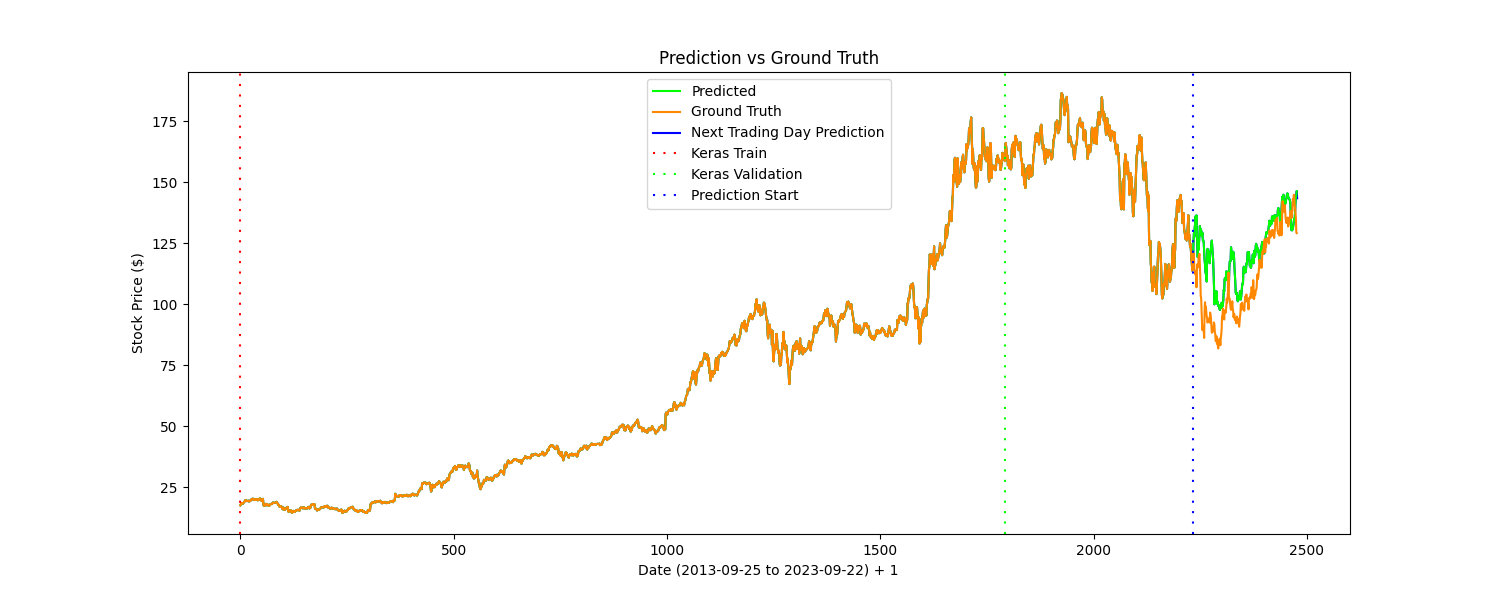

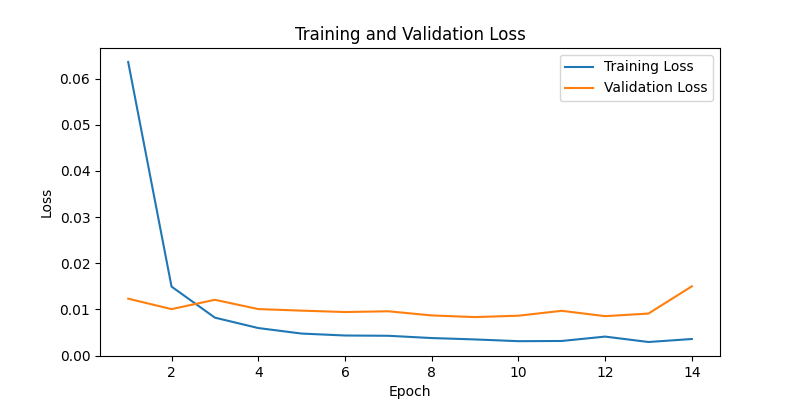

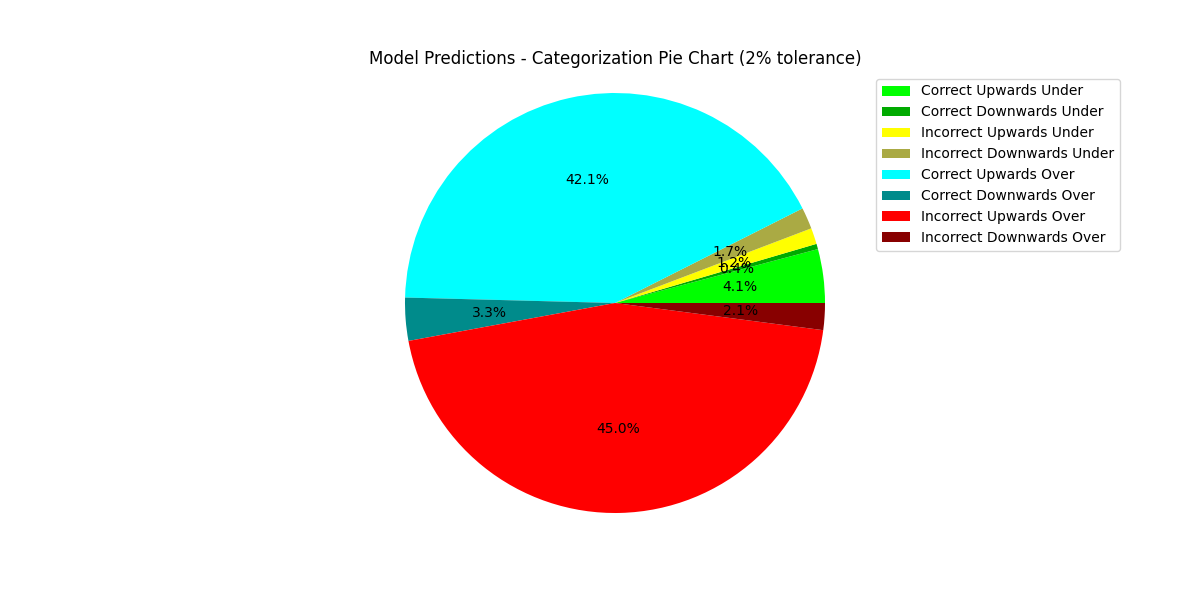

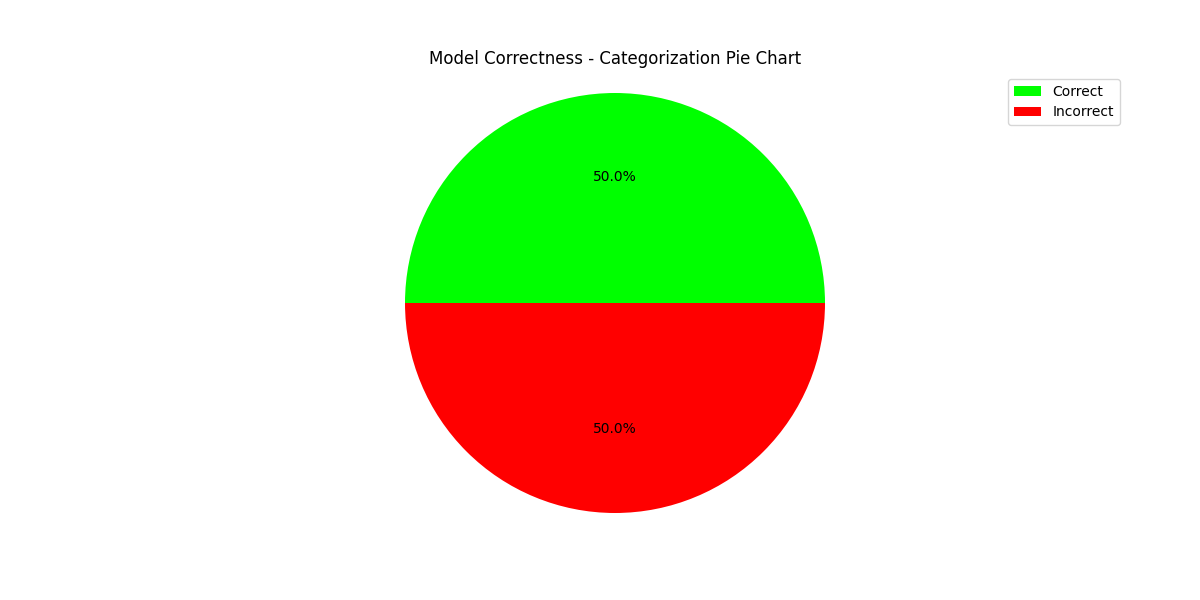

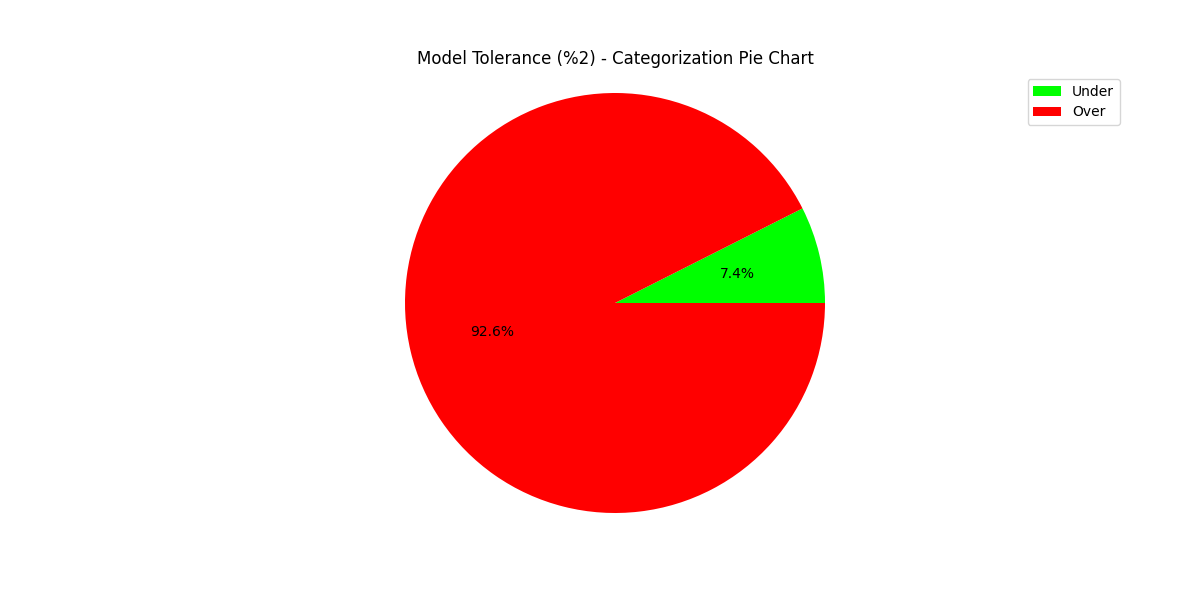

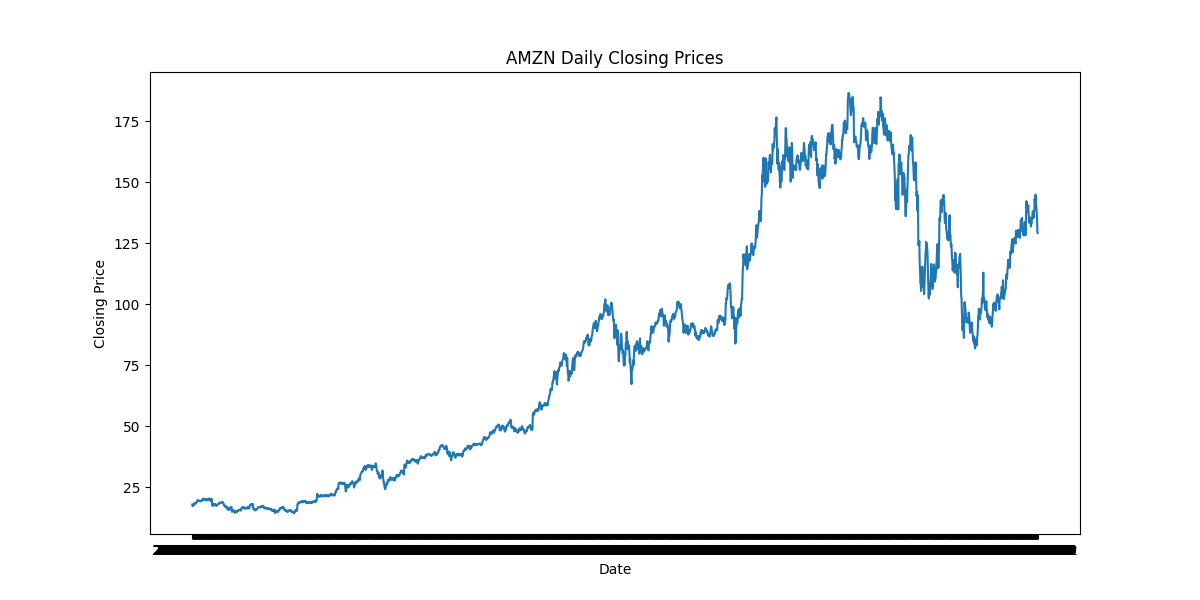

C:\Users\jaime\AppData\Local\Temp\ipykernel_32696\4043310921.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


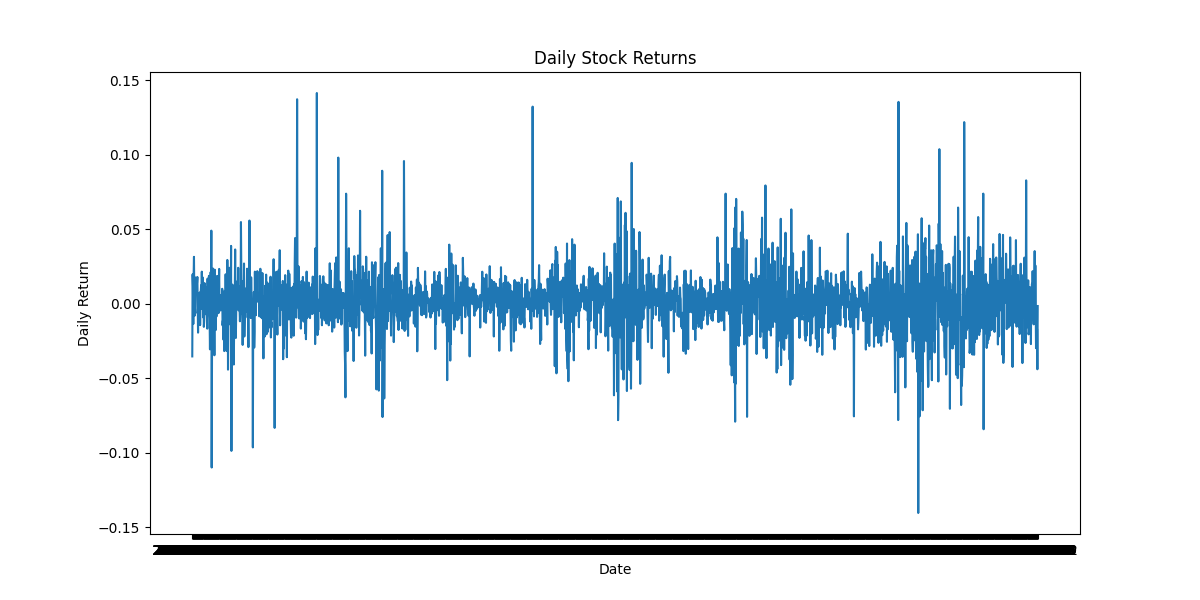

In [164]:
plot_prediction_vs_gt()
plot_loss_chart()
plot_pie_categories()
plot_pie_correctness()
plot_pie_tolerance()
plot_daily_close()
plot_daily_returns()

In [165]:
#plt.close('all')